In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image


In [2]:

# ✅ Clone GitHub Repository (Ensure dataset is inside)
!git clone https://github.com/EASWAR17/dataset.git
DATASET_PATH = "/content/dataset/processedData"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

Cloning into 'dataset'...
remote: Enumerating objects: 862, done.
remote: Counting objects: 100% (862/862), done.
remote: Compressing objects: 100% (859/859), done.
remote: Total 862 (delta 1), reused 859 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (862/862), 36.76 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
# Define dataset paths
train_dir = os.path.join(DATASET_PATH, "train")
val_dir = os.path.join(DATASET_PATH, "val")
test_dir = os.path.join(DATASET_PATH, "test")

In [4]:
# Image augmentation & preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load dataset
train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


Found 699 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [7]:
# Load pre-trained model (choose VGG16 or ResNet50)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

In [9]:
# Build final model
model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train model
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6784 - loss: 3.4641 - val_accuracy: 0.9697 - val_loss: 0.1602
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - accuracy: 0.8912 - loss: 0.2709 - val_accuracy: 0.9596 - val_loss: 0.1195
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.9404 - loss: 0.1492 - val_accuracy: 0.9899 - val_loss: 0.0874
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.9543 - loss: 0.1056 - val_accuracy: 0.9899 - val_loss: 0.1005
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.9806 - loss: 0.0785 - val_accuracy: 0.9899 - val_loss: 0.0721
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.9737 - loss: 0.0813 - val_accuracy: 0.9899 - val_loss: 0.0978
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.9824 - loss: 0.0593 - val_accuracy: 0.9899 - val_loss: 0.0794
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9739 - loss: 0.0624 - val_accurac

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


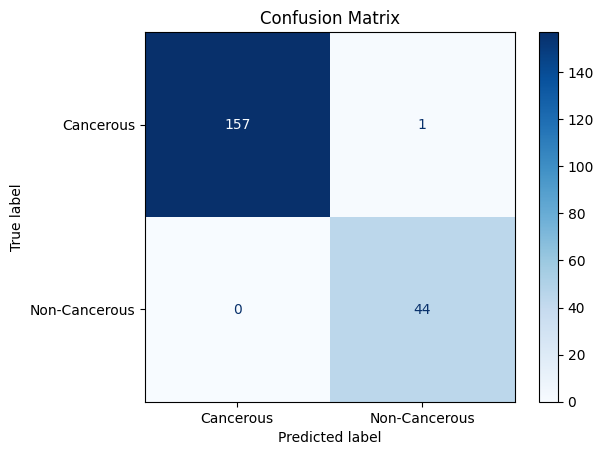

In [15]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancerous","Non-Cancerous"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

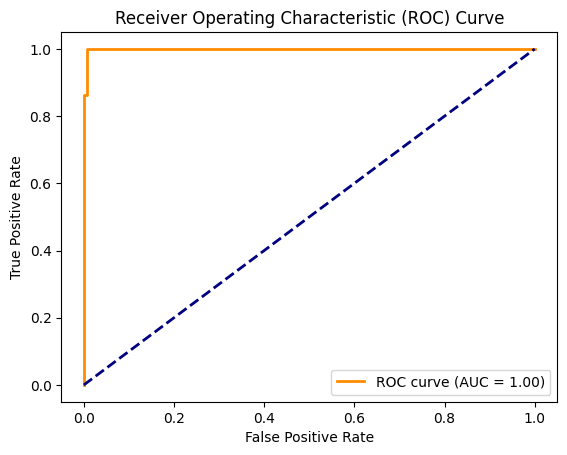

In [16]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

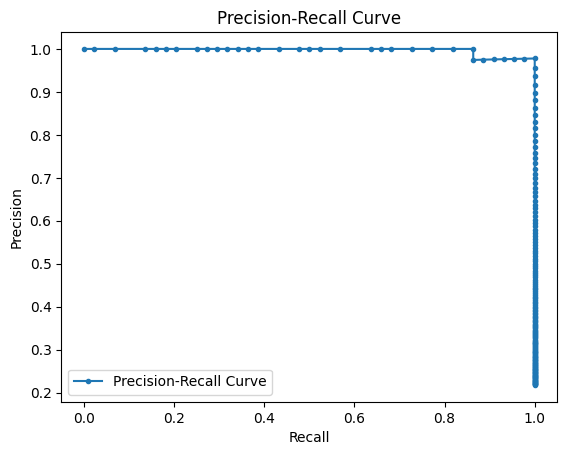

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(true_labels, pred_probs)

plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

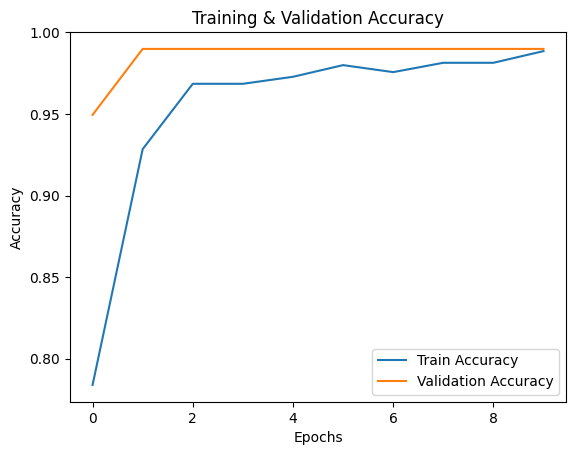

In [18]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()


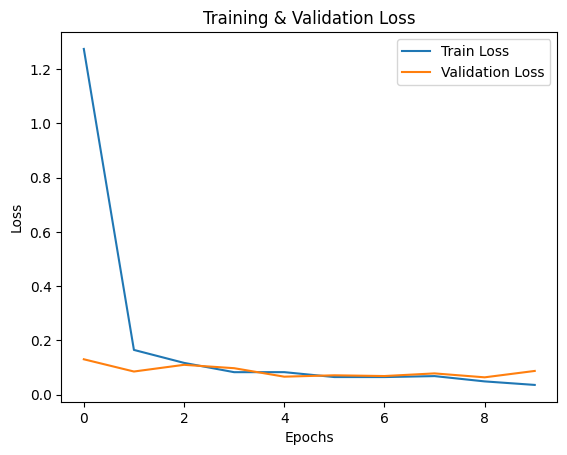

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [20]:
MODEL_SAVE_PATH = "/content/lung_cancer_model_vgg_v2.h5"
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /content/lung_cancer_model_vgg_v2.h5


In [6]:

from tensorflow.keras.models import load_model

# Load the model
model = load_model("/content/lung_cancer_model_vgg.h5")

# Recompile the model with your desired settings
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



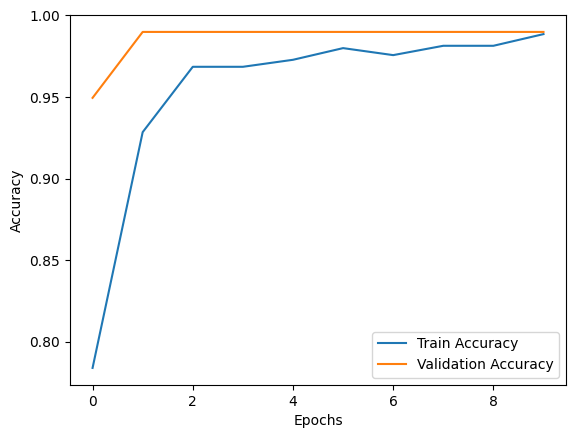

In [21]:
# Plot training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Prediction function
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    return "Cancerous" if prediction < 0.5 else "Non-Cancerous"

In [ ]:
/content/lung-cancer-detection/processedData/test/cancerous/adenocarcinoma150.png

In [12]:
sample_image_path = os.path.join(DATASET_PATH, 'test/cancerous/large.cell.carcinoma70.png')  # Replace with your test image
print("Prediction:", predict_image(sample_image_path, model))
# generate_gradcam(model, sample_image_path)
# explain_with_shap(model, sample_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Cancerous


In [8]:
# # Grad-CAM Implementation
import cv2
def generate_gradcam(model, img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    grad_model = Model(inputs=model.input, outputs=[model.get_layer('block5_conv3').output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# def generate_gradcam(model, img_path):
#     img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed
#     img_array = image.img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     # Get model output from block5_conv3
#     grad_model = Model(inputs=model.input, outputs=[model.get_layer('block5_conv3').output, model.output])

#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         loss = predictions[:, 0]  # Change index if multi-class

#         # Ensure gradient tracking
#         tape.watch(conv_outputs)

#     grads = tape.gradient(loss, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # Fix broadcasting issue
#     pooled_grads = tf.reshape(pooled_grads, (1, 1, -1))

#     conv_outputs = conv_outputs[0]
#     heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

#     # Normalize heatmap safely
#     heatmap = np.maximum(heatmap, 0)
#     if np.max(heatmap) != 0:
#         heatmap /= np.max(heatmap)

#     # Load original image
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (224, 224))  # Ensure same size
#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))


#     # Convert heatmap to color
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Overlay heatmap on image
#     superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

#     # Display result
#     plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

In [35]:
pip install --upgrade shap


In [18]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def explain_with_shap(model, img_path, train_generator):
    # Ensure model is a Keras Model
    if not isinstance(model, tf.keras.Model):
        raise ValueError("The provided model is not a Keras model. Ensure you are passing a valid tf.keras.Model.")

    # Load and preprocess the input image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Model expects batch input

    # Extract a SINGLE background image (not a batch)
    background, _ = next(iter(train_generator))
    background = np.array(background[:1])  # Use only ONE image
    background = background[0]  # Remove batch dimension

    # Convert to 3 channels if grayscale
    if background.shape[-1] != 3:
        background = np.repeat(background, 3, axis=-1)

    # Resize if necessary
    if background.shape != (224, 224, 3):
        background = tf.image.resize(background, (224, 224)).numpy()

    # Convert background to float32 for SHAP
    background = background.astype(np.float32)

    # Ensure the background image has a batch dimension for SHAP
    background = np.expand_dims(background, axis=0)  # Convert to (1, 224, 224, 3)

    # Debugging: Print shape before passing to SHAP
    print("Background shape:", background.shape)  # Should be (1, 224, 224, 3)

    # ✅ Fix: Explicitly specify input shape for SHAP
    masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))  # Explicit shape

    # SHAP Explainer
    explainer = shap.Explainer(model, masker)

    # Compute SHAP values
    shap_values = explainer(img_array)

    # Display SHAP explanation
    shap.image_plot(shap_values, img_array)

# Call the function
#explain_with_shap(model, sample_image_path, train_generator)


In [16]:

# def explain_with_shap(model, img_path, train_generator):
#     # Ensure model is a Keras Model
#     if not isinstance(model, tf.keras.Model):
#         raise ValueError("The provided model is not a Keras model. Ensure you are passing a valid tf.keras.Model.")

#     # 1. Create a new model that outputs the block5_conv1 layer
#     intermediate_model = Model(inputs=model.input, outputs=model.get_layer('block5_conv1').output)

#     # Load and preprocess the input image
#     img = image.load_img(img_path, target_size=(224, 224))
#     img_array = image.img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)  # Model expects batch input

#     # Extract a SINGLE background image (not a batch)
#     background, _ = next(iter(train_generator))
#     background = np.array(background[:1])  # Use only ONE image
#     background = background[0]  # Remove batch dimension

#     # Convert to 3 channels if grayscale
#     if background.shape[-1] != 3:
#         background = np.repeat(background, 3, axis=-1)

#     # Resize if necessary
#     if background.shape != (224, 224, 3):
#         background = tf.image.resize(background, (224, 224)).numpy()

#     # Convert background to float32 for SHAP
#     background = background.astype(np.float32)

#     # Ensure the background image has a batch dimension for SHAP
#     background = np.expand_dims(background, axis=0)  # Convert to (1, 224, 224, 3)

#     # Debugging: Print shape before passing to SHAP
#     print("Background shape:", background.shape)

#     # ✅ Fix: Explicitly specify input shape for SHAP
#     #The output shape for the conv layer will be (None, 14, 14, 512), we will mask along the spatial dimensions
#     masker = shap.maskers.Image("inpaint_telea", (14,14,512))  # Output shape of block5_conv1

#     # SHAP Explainer - Use the intermediate model
#     explainer = shap.Explainer(intermediate_model, masker)

#     # Compute SHAP values, now with the intermediate model and the correct shape.
#     shap_values = explainer(img_array)

#     # Get the output of the intermediate layer for the input image
#     intermediate_output = intermediate_model(img_array)

#     # Display SHAP explanation
#     # display with intermediate output instead of original image
#     shap.image_plot(shap_values, intermediate_output)

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,983,813 (129.64 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,846,084 (49.00 MB)

In [ ]:
/content/lung-cancer-detection/processedData/test/non-cancerous/normal108.png

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Cancerous


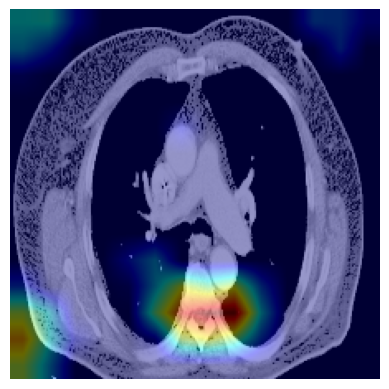

In [10]:
# Example prediction

sample_image_path = "/content/dataset/processedData/test/cancerous/large.cell.carcinoma70.png"
print("Prediction:", predict_image(sample_image_path, model))
generate_gradcam(model, sample_image_path)


Background shape: (1, 224, 224, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.46s/it]               


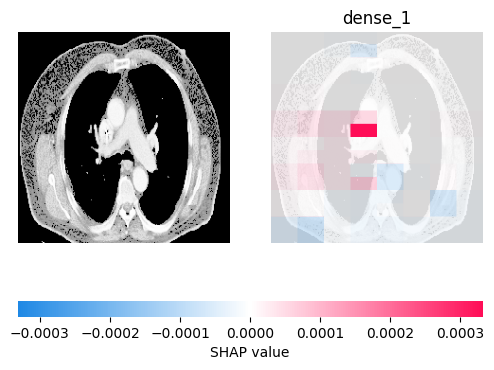

In [19]:
explain_with_shap(model, sample_image_path, train_generator)


In [26]:
# ✅ Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 962ms/step - accuracy: 0.9973 - loss: 0.0124
Test Accuracy: 0.9950
